# Retinal Vasculature Segmentation using U-net 

## 1) Import required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf 
import h5py
import random
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.grid(b=None)
%matplotlib inline

from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, UpSampling2D

## 2) Define ```ImageDataGenerator``` for images and their masks

* We add augmentations to improve model performance as we have very few images
* **seed** value is important as it makes sure that iamges and their masks are joined in order
* I've used ```batch_size = 1``` due to H/W limitations

In [2]:
train_args = dict(
             rescale=1./255,
             rotation_range=90,
             horizontal_flip = True,
             vertical_flip = True,
             width_shift_range=0.1,
             height_shift_range=0.1,
             zoom_range=0.2)

def get_generator(IMAGE_PATH,MASK_PATH,TARGET_SIZE=(512,512), train=True):
    if train:
        image_datagen = ImageDataGenerator(**train_args)    
        mask_datagen = ImageDataGenerator(**train_args)
    else:
        image_datagen = ImageDataGenerator(rescale=1./255)    
        mask_datagen = ImageDataGenerator(rescale=1./255)
    
    image_gen = image_datagen.flow_from_directory(
        IMAGE_PATH,
        target_size = TARGET_SIZE,
        class_mode=None,
        batch_size = 1,
        seed = 21)
    mask_gen = mask_datagen.flow_from_directory(
        MASK_PATH,
        target_size = TARGET_SIZE,
        class_mode=None,
        batch_size = 1,
        seed = 21)
    return zip(image_gen, mask_gen)

## 3) Define U-Net architecture

In [3]:
def unet(input_size = (512,512,3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal',
                                padding='same')(c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()

    return model

## 4) Get images 

In [4]:
print("Training Set:")
train_generator = get_generator("images/train/origin","images/train/groundtruth",(512,512), train=True)

print("\nValidation Set:")
val_generator = get_generator("images/val/origin","images/val/groundtruth",(512,512), train=False)

print("\nTest Set:")
test_generator = get_generator("images/test/origin","images/test/groundtruth",(512,512), train=False)


Training Set:
Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


/home/abhiroop/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '



Validation Set:
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.

Test Set:
Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.


## 5) View a random retinal image and its mask

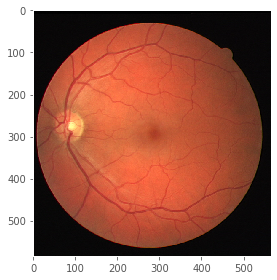

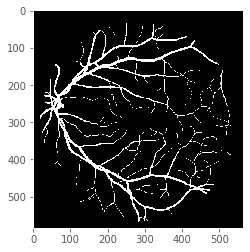

In [5]:
orig_dir = "images/train/origin/img/"
gt_dir = "images/train/groundtruth/img/"

def plot_image(orig_dir, gt_dir):
    original_image = imread(orig_dir + random.choice(os.listdir(orig_dir)))
    imshow(original_image)
    plt.grid(b=None)
    plt.show()

    groundtruth_image = Image.open(gt_dir + random.choice(os.listdir(gt_dir))).convert("L")
    arr = np.asarray(groundtruth_image)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.grid(b=None)
    plt.show()
    
plot_image(orig_dir, gt_dir)

## 6) Initialize a new U-Net 

In [6]:
model = unet((512,512,3))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

## 7) Define some callbacks and train the model

In [7]:
es = EarlyStopping(monitor='val_loss',patience=3,verbose=1)
mc = ModelCheckpoint("best_weights.hdf5",monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit_generator(train_generator,
                   epochs=20,
                   verbose=1,
                   steps_per_epoch=25,
                   callbacks=[es,mc],
                   validation_data=val_generator,
                   validation_steps=10)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 10 steps
Epoch 1/20
24/25 [===========================>..] - ETA: 1s - loss: 0.4334 - accuracy: 0.8309
Epoch 00001: val_loss improved from inf to 0.27274, saving model to best_weights.hdf5
25/25 [==============================] - 55s 2s/step - loss: 0.4295 - accuracy: 0.8312 - val_loss: 0.2727 - val_accuracy: 0.9135
Epoch 2/20
24/25 [===========================>..] - ETA: 1s - loss: 0.2723 - accuracy: 0.8727
Epoch 00002: val_loss improved from 0.27274 to 0.27270, saving model to best_weights.hdf5
25/25 [==============================] - 51s 2s/step - loss: 0.2703 - accuracy: 0.8738 - val_loss: 0.2727 - val_accuracy: 0.9114
Epoch 3/20
24/25 [===========================>..] - ETA: 2s - loss: 0.2594 - accuracy: 0.8780
Epoch 00003: val_loss improved from 0.27270 to 0.26528, saving model to best_weights.hdf5
25/25 [===================

## 8) Plot learning curves

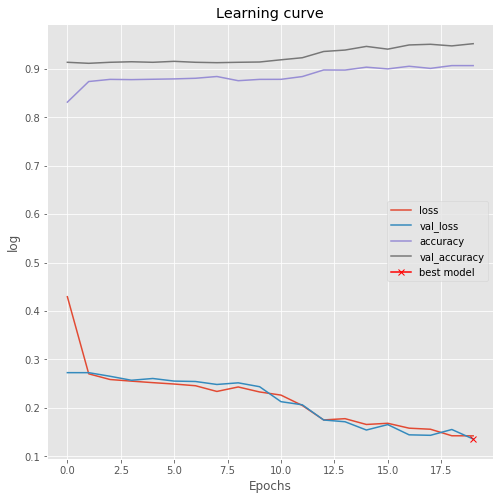

In [8]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log")
plt.legend()

## 9) Load best weights and evaluate on test set

In [9]:
model.load_weights("best_weights.hdf5")
model.evaluate_generator(test_generator,10, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
10/10 [==============================] - 5s 535ms/step - loss: 0.1272 - accuracy: 0.9548


[0.12724231779575348, 0.95483625]

## 10) Plot a predicted mask 

* First view the retinal image and mask
* Then predict and plot the predicted mask

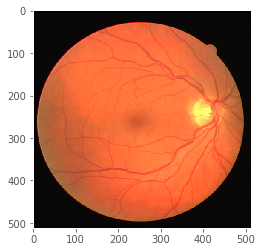

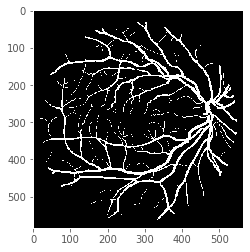

In [14]:
test_dir = "images/test/origin/img/"
testgt_dir = "images/test/groundtruth/img/"
random.seed(20)
# Load image
img = imread(test_dir + random.choice(os.listdir(test_dir)))
img = resize(img, (512,512), mode='constant', preserve_range=True)
plt.imshow(np.array(img,np.int32))
plt.grid(b=None)
plt.show()

# Load mask
random.seed(20)
image = Image.open(testgt_dir + random.choice(os.listdir(testgt_dir))).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.grid(b=None)
plt.show()


In [15]:
img = np.expand_dims(img, axis=0)
preds = model.predict(img, verbose=1)

1/1 [==============================] - 0s 484ms/sample


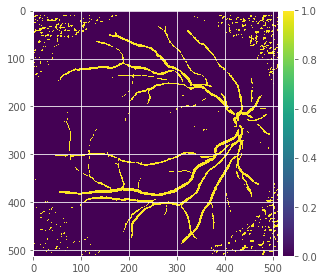

In [25]:
preds_t = (preds>0.5).astype(np.uint8)
imshow(np.squeeze(preds_t))
plt.savefig('images/pred_mask.png')
plt.show()